# Creating a monthly NEE dataset, using CarbonTracker model

This notebook outlines the workflow for creating a monthly NEE dataset. You first need to have run the CarbonTracker workflow to train and create the model. 

To create the dataset you need:

- CarbonTracker model
- ERA5 (monthly)
- ERA5-land (monthly)
- SPEI (monthly)
- MODIS (monthly)
- Biomass (yearly)
- Copernicus Landcover (yearly)


In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import xarray as xr
from dask.distributed import Client

import excited_workflow
from excited_workflow import monthly_nee
from excited_workflow.source_datasets import datasets


client = Client()

Define the paths needed for the carbon tracker dataset, regions dataset, model that contains the model and data directory. Define desired data, x keys and y key for the model. 

In [2]:
home_path = Path.home()
data_dir = home_path / "data/volume_2"
cb_file= data_dir / "EXCITED_prepped_data/CT2022.flux1x1-monthly.nc"
regions_file = data_dir / "EXCITED_prepped_data/regions.nc"
model_dir = sorted(list(home_path.rglob("carbon_tracker-*")))[-1]


desired_data = [
    "biomass",
    "spei",
    "modis",
    "era5_monthly",
    "era5_land_monthly",
    "copernicus_landcover"
]

x_keys = ["d2m", "mslhf", "msshf", "ssr", "str", "t2m", "spei", "NIRv", "skt",
            "stl1", "swvl1", "lccs_class"]
y_key = "bio_flux_opt"

Merge the desired datasets into a single xr.Dataset with the same dimensions as the carbon tracker dataset. 

In [3]:
ds_cb = xr.open_dataset(cb_file)
ds_cb = excited_workflow.utils.convert_timestamps(ds_cb)
ds_regions = xr.open_dataset(regions_file)
ds_input = xr.merge(
    [
        datasets[name].load(freq="monthly", target_grid=ds_cb)
        for name in desired_data
    ]
)

Run prediction model for each month where all data is available.

In [5]:
dfs, times = monthly_nee.get_predictions(ds_input, x_keys, ds_regions, 
                                                         model_dir)

Create a NEE dataset with all prediction arrays and save as a netcdf. 

In [6]:
ds_out = monthly_nee.create_dataset(dfs, times, data_dir)

Plot NEE to check everything worked correctly. 

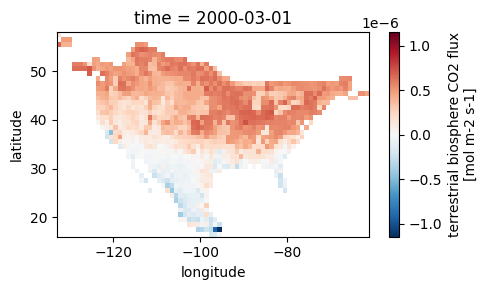

In [10]:
plt.figure(figsize=(5,3))
ds_out["bio_flux"].isel(time=0).plot()
plt.tight_layout()